# Lecture 11 — Bayesian Statistical Inference: IV

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026//blob/main/Lectures/Lecture_11_PDM.ipynb)


**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.

##### For those who want to dive deep:

- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.
- [Using Markov Chain Monte Carlo](https://arxiv.org/abs/1710.06068) by Hogg and Foreman-Mackey 


___



Make sure the python packages `emcee` and `pymc3` are installed.

>## Practical MCMC <a class="anchor" id="one"></a>

In [20]:
import numpy as np
from scipy import stats, integrate
from scipy.stats import norm, cauchy
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.simplefilter('ignore')

# Don't use LaTeX on systems without a full TeX install (common on HPC/Colab)
plt.rcParams.update({
    "font.size": 8,
    "text.usetex": False,
})

In [21]:

#these need to be defined since astroML plotting is not working in this environment
def hist(ax, data, bins=30, density=True, **kwargs):
    """Simple replacement for astroML.plotting.hist."""
    return ax.hist(data, bins=bins, density=density, **kwargs)

In [22]:
#these need to be defined since astroML plotting is not working in this environment
def convert_to_stdev(logp):
    """
    Convert a 2D log-probability grid into 'sigma-equivalent' contour levels.

    Returns a grid of cumulative probability values (0..1) sorted by descending density.
    Then you contour at levels [0.683, 0.955, 0.997].
    """
    logp = np.asarray(logp)

    # stabilize
    p = np.exp(logp - np.max(logp))

    # normalize to sum to 1 (discrete approximation to integral)
    p /= np.sum(p)

    # sort probabilities descending
    p_flat = p.ravel()
    idx = np.argsort(p_flat)[::-1]
    p_sorted = p_flat[idx]

    # cumulative sum of sorted probabilities
    cdf_sorted = np.cumsum(p_sorted)

    # map cumulative values back to original grid shape
    cdf = np.empty_like(p_flat)
    cdf[idx] = cdf_sorted
    return cdf.reshape(p.shape)

### Practical MCMC chain checks

1. **CHECK ACCEPTANCE:** some MCMC samplers give an updating estimate of the current acceptance rate of new samples. Ideally for a sampler using some form of Metropolis-Hastings, this should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve.

    - If the acceptance rate is high, the chain is moving but might not be exploring well. This gives high acceptance rate but poor global exploration of the posterior surface.
    
    - If the acceptance rate is low, the chain is hardly moving meaning that it's stuck in a rut or trying to jump to new points that are too far away.
    

2. **CHECK TRACEPLOTS:** After getting an idea of the acceptance rate, make traceplots of your chain. Ideally, our traceplot in each parameter would be mixing well (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. This will tell you whether your chain is getting stuck or encountering inefficiencies.


3. **CHECK AUTOCORRELATION LENGTH:** The MCMC chain with Metropolis-Hastings will not give fully-independent random samples. The next point is influenced by where the previous point was. We need to check how much to down-sample the chain so that the points lack memory and influence from others. This is given by the ***autocorrelation length***. The operation of selecting samples every other autocorrleation lenght is called ***thinning***.

For a recent in depth discussion see [Roy (2019)](https://arxiv.org/abs/1909.11827)

For a discussion on the mathematical definition of the autocorrelation, the [emcee documentation](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) is particularly clear.

>## Optimizing sampling: how to move efficiently through parameter space

In basic Metropolis–Hastings, we propose new points by adding random noise to the
current position. While this always works *in principle*, it can be **very slow**
in practice:

- If steps are too small, the chain moves like a random walk and mixes slowly.
- If steps are too large, most proposed points are rejected.
- If parameters are correlated, proposals often move in inefficient directions.

The goal of **optimized sampling** is simple:

> **Propose new points that follow the shape of the posterior distribution, so
> that we explore it efficiently.**

Below are several commonly used strategies that address this problem in different
ways.

---

### (a) Adaptive Metropolis (AM)

**Idea:**  
Learn the *shape* of the posterior from the chain itself and use that information
to propose better steps.

As the chain runs, we can estimate the **covariance matrix** of the parameters.
This matrix tells us:
- how wide the posterior is in each direction,
- which parameters are correlated.

We then use this covariance matrix to construct a multivariate Gaussian proposal
distribution that is aligned with the posterior.

**Intuition:**  
Instead of proposing circular “blobs” in parameter space, we propose **ellipses
that match the posterior geometry**.

**In practice:**
- Estimate the parameter covariance matrix $C$ from the chain history.
- Use it to propose jumps that follow the dominant directions of variation.
- Scale the jump size by
  $$
  \alpha = \frac{2.38^2}{N_\mathrm{param}},
  $$
  which empirically gives a good acceptance rate ($\sim 20\!-\!30\%$).

**Important subtlety:**  
Because the proposal depends on the *entire past history* of the chain, the
process is no longer strictly Markovian. The standard workaround is:

> Use Adaptive Metropolis only during an initial **tuning phase**, then freeze
> the proposal distribution and continue sampling normally.

---

### (b) Single Component Adaptive Metropolis (SCAM)

**Problem addressed:**  
In high-dimensional or strongly correlated posteriors, full multivariate jumps
can still be inefficient.

**Idea:**  
Instead of jumping in *all* directions at once, jump along **one important
direction at a time**.

This is done by:
- diagonalizing the covariance matrix to find its principal axes,
- randomly selecting one axis,
- proposing a jump *only along that axis*.

**Intuition:**  
This is similar to updating one *uncorrelated parameter* at a time, but in a
rotated coordinate system where correlations have been removed.

**Why this helps:**
- Higher acceptance rates,
- Better exploration when parameters are tightly coupled.

---

### (c) Differential Evolution (DE)

**Idea:**  
Use the chain’s own history to propose intelligent jumps.

Instead of drawing a random step, we:
- pick two previous samples from the chain,
- take their difference vector,
- jump along that direction.

Mathematically:
$$
y = x_i + \beta (x_{r1} - x_{r2}),
$$
where $x_{r1}$ and $x_{r2}$ are randomly chosen past samples.

**Intuition:**  
If the chain has already explored the posterior reasonably well, the differences
between past samples naturally point along **high-probability directions**.

**Why this works well:**
- Automatically adapts to the posterior shape,
- Very effective for multimodal or elongated distributions,
- Requires no gradients.

---

### (d) Hamiltonian Monte Carlo (HMC)

**Idea:**  
Instead of proposing random jumps, use **deterministic trajectories** guided by
the gradient of the posterior.

HMC treats parameters like positions of a particle moving in a potential:
$$
U(\theta) = -\log p(\theta \mid D).
$$

By following Hamilton’s equations, the sampler:
- moves rapidly through high-probability regions,
- avoids random-walk behavior,
- produces low-autocorrelation samples.

**Trade-off:**  
HMC requires computing **derivatives of the likelihood**, which can be expensive
or unavailable in some problems.

---

## The “proposal cocktail”: how real MCMC works

In real analyses, no single proposal strategy works best everywhere. Modern MCMC
codes therefore use a **mixture of proposal schemes**, for example:

- Adaptive Metropolis (global shape),
- SCAM (local, directional moves),
- Differential Evolution (history-based jumps),
- Occasional draws from the prior (large exploratory moves).

At each iteration, one of these schemes is chosen at random according to fixed
weights.

**Why include prior draws?**  
They allow the chain to occasionally make very large jumps, helping it:
- escape local maxima,
- explore disconnected regions of parameter space.

As long as each proposal is properly accounted for in the Metropolis–Hastings
acceptance probability, **detailed balance is preserved** and the sampler
remains correct.

---

### Big-picture takeaway

- Good sampling is about **geometry**, not brute force.
- Optimized proposals reduce burn-in, increase acceptance, and shorten
  autocorrelation times.
- The best samplers adapt to the posterior **without violating the rules of
  MCMC**.

>## MCMC Parameter Estimation *In the Wild* <a class="anchor" id="two"></a>

So far, we have discussed MCMC mostly at a conceptual level. In real research,
however, nobody writes samplers from scratch unless absolutely necessary.
Instead, we rely on well-tested, community-developed software packages.

Below we briefly introduce some widely used samplers in physics, astronomy,
cosmology, and data science, and explain **why different communities favor
different tools**.


### emcee

> The `emcee` package (also known as the *MCMC Hammer*) is a pure-Python package
written by astronomer Dan Foreman-Mackey. It implements an **affine-invariant
ensemble sampler**, which is particularly robust for problems with strong
parameter degeneracies.

Key features of `emcee`:
- Minimal boilerplate: you only provide a function proportional to the
  log-posterior.
- Uses an **ensemble of walkers** rather than a single chain.
- Automatically adapts to linear correlations between parameters.
- Very easy to install and debug.

`emcee` is extremely popular in astrophysics and gravitational-wave astronomy,
where likelihoods can be complicated but gradients are not always available.


### PyMC

`PyMC` is a much more **general probabilistic programming framework**.

Key features of PyMC:
- Explicit syntax for defining probabilistic models (priors, likelihoods,
  hierarchies).
- Automatic selection of advanced samplers such as **Hamiltonian Monte Carlo
  (HMC)** and **No-U-Turn Sampler (NUTS)**.
- Strong support for hierarchical Bayesian models.
- Automatic differentiation of the log-posterior.

PyMC is widely used in:
- statistics,
- machine learning,
- economics,
- increasingly also in physics.


>## Cosmology-focused samplers

In cosmology, parameter inference often involves:
- high-dimensional parameter spaces (10–30 parameters),
- expensive likelihoods (Boltzmann solvers, power spectra),
- strong parameter degeneracies,
- the need for **model comparison** and **Bayesian evidence**.

As a result, the cosmology community has developed its own specialized tools.


### CosmoMC

`CosmoMC` is a long-standing Fortran-based MCMC code developed primarily for
cosmic microwave background (CMB) analysis.

Key features:
- Optimized for cosmological parameter estimation.
- Implements fast proposal tuning and covariance learning.
- Interfaces with Boltzmann codes such as CAMB.
- Widely used in Planck-era cosmology.

**Historically:**  
CosmoMC set the standard for precision cosmological inference for over a decade.

### Cobaya (modern replacement)

`Cobaya` is a **modern Python framework** that generalizes and largely replaces
CosmoMC.

Key features:
- Clean separation between likelihoods, priors, and samplers.
- Supports multiple samplers (Metropolis, HMC, nested sampling).
- Designed for reproducibility and modularity.
- Interfaces naturally with cosmological theory codes.
  
Cobaya plays a role in cosmology similar to PyMC in statistics: it is a flexible
*inference engine* rather than just a sampler.


>## Nested sampling and evidence calculation

Standard MCMC is excellent for estimating **posterior distributions**, but it is
not well suited for computing the **Bayesian evidence** required for model
comparison.

For this reason, cosmology and particle physics often rely on **nested sampling**
algorithms.


### MultiNest and PolyChord

Nested samplers such as `MultiNest` and `PolyChord` are designed to:
- efficiently explore multimodal posteriors,
- handle strong degeneracies,
- compute Bayesian evidence accurately.

`PolyChord`, in particular, is optimized for **high-dimensional problems** and
is widely used in modern cosmological analyses.

**Key difference from MCMC:**
- MCMC explores *where probability is high*.
- Nested sampling explores *how probability volume is distributed*, which is
  essential for evidence calculations.


In this course we will mostly work with emcee and pyMC because they can be easily used as stand-alone samplers. For the research project you might be encouraged to work with more dedicated samplers. 


##  MCMC with emcee <a class="anchor" id="three"></a>

Import `emcee` and generate some homoescedastic Gaussian data. We'll assume the standard deviation is know, so we're only estimating $\mu$.

In [ ]:
# ------------------------------------------------------------
# Check and install required packages (emcee, pymc)
# Works on Google Colab and most HPC Jupyter setups
# ------------------------------------------------------------

import sys
import subprocess

def install_if_missing(package, import_name=None):
    """
    Check whether a package can be imported; if not, install it with pip.
    """
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "--quiet", package]
        )
        print(f"✓ {package} installed")

# Core samplers used in this lecture
install_if_missing("emcee")
install_if_missing("pymc", import_name="pymc")

In [ ]:
import emcee

np.random.seed(21)
# Generate synthetic data
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

Define all the relevant functions.

In [ ]:
def Likelihood(x, sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2 /2 /sigma**2))

def Prior(x):
    return 1.0 / 10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

`emcee` combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers $\times$ nsteps.

In [ ]:
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

In [ ]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

So you see thatt he size of the final chain is 6*(5000-1000) = 24000

In [ ]:
emcee_trace.flatten()

In [ ]:
# plot 
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(15, 8))
#fig.subplots_adjust(left=0.11, right=0.95, 
                   # wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number',fontsize=15)
plt.ylabel('chain',fontsize=15)

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend(fontsize=15)

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE[xgrid>Nburn], 
                                bins='auto', histtype='stepfilled')

# plot expectations based on central limit theorem, for comparison
binwidth = bins[1] - bins[0] 
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
# Gaussian from CLT
gauss = Nchain * binwidth * stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)',fontsize=15)
ax2.set_xlabel('chain values',fontsize=15)
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee',fontsize=15)

##  MCMC with PyMC <a class="anchor" id="four"></a>

Now we will use pyMC to get a 2-dimensional posterior pdf for location and scale parameters using a sample drawn from a **Cauchy distribution**. Remember a Cauchy distribution formally has no mean or standard deviation because its tails fall off shallower than $1/x^2$.

The following is code adapted from Figure 5.22 of the textbook. Initially, we load in `PyMC3` and define the Cauchy log likelihood. 

***NOTE:*** The code here for the Cauchy likelihood is actually only for when we look at the analytic estimate, since `PyMC3` has ready-made modules for many standard functions!

In [2]:
import numpy as np
import pymc as pm

print("PyMC version:", pm.__version__)
print("NumPy version:", np.__version__)

PyMC version: 5.27.0
NumPy version: 2.3.5


In [3]:

from scipy.stats import cauchy

# Define the Cauchy log-likelihood function
def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    
    xi = np.asarray(xi)
    n = xi.size
    # determine the shape for broadcasting; without braodcasting we would need to write loops. 
    # broadcasting makes sure arrays are the same shape for arithmetic operations
    shape = np.broadcast(sigma, mu).shape
    # reshape xi to enable broadcasting and hence avoid loops
    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    #now compute the log likelihood using the reshaped arrays savely:
    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

Generate some data from the Cauchy distribution.

In [4]:
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

In [5]:
print("len(xi) =", len(xi))
print("min/max =", np.min(xi), np.max(xi))

len(xi) = 10
min/max = -5.853754966048442 3.5023364775061836


Set up the `PyMC` model.

In [7]:
# ------------------------------------------------------------
# Define and run a Bayesian model using PyMC (Metropolis sampler)
# ------------------------------------------------------------

import numpy as np
import pymc as pm

# Build the probabilistic model
with pm.Model():

    # Prior on the Cauchy location parameter μ
    # We assume μ could plausibly lie anywhere between -5 and 5
    mu = pm.Uniform(
        name="mu",
        lower=-5,
        upper=5
    )

    # Prior on the logarithm of the Cauchy scale parameter γ
    # Sampling in log-space ensures γ > 0 and allows exploration
    # across a wide (but still reasonable) range of scales.
    #
    # Here: γ ∈ [exp(-5), exp(3)] ≈ [0.0067, 20]
    log_gamma = pm.Uniform(
        name="log_gamma",
        lower=-5,
        upper=3
    )

    # Likelihood:
    # Each observed data point x_i is assumed to be drawn from
    # a Cauchy distribution with location μ and scale γ = exp(log_gamma)
    x = pm.Cauchy(
        name="x",
        alpha=mu,
        beta=np.exp(log_gamma),
        observed=xi
    )

    # Choose an MCMC step method explicitly:
    # Metropolis is robust and portable (no gradients required), which is why
    # we use it here for a course notebook that should run on HPC/Colab.
    step = pm.Metropolis()

    # Draw samples from the posterior distribution
    # - tune: number of warm-up (burn-in) steps (discarded)
    # - draws: number of samples kept after tuning
    # - chains: independent chains started at different initial points
    # - cores=1: safer for HPC login nodes and Jupyter environments
    # - progressbar=False: avoids IPyWidgets rendering issues in VS Code
    trace = pm.sample(
        draws=2000,
        tune=500,
        chains=2,
        cores=1,
        step=step,
        progressbar=False,
        compute_convergence_checks=False,
        random_seed=42
    )

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [log_gamma]
Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 1 seconds.


If we had not defined step = pm.Metroplis, the PySM will decide the optimal sampler. In that case, you would see some output messages along the lines of "Auto-assigning NUTS sampler...". `PyMC3` is very sophisticated, and will automatically decide for you the best tools for the job. 

In this case, it would decide you needed **No-U-Turn Hamiltonian gradient-based sampling**, where gradient information about the Cauchy likelihood helped in the exploration of parameter space. 

On shared systems (such as HPC clusters or remote notebooks), advanced samplers like NUTS can sometimes appear to “run forever” due to numerical or backend issues; to avoid this, we start with short test runs and check some diagnostics to confirm that the sampler is behaving correctly before trusting the results. If the code below takes too long, this suggest you are running into the same issue I had (which I since have been able to fix). 

In [16]:
#here is a snippet to run NUTS with a timeout. You can check if this works on your system. If it does, kuddos, and you can increase the prior ranges and the number of draws/tuning steps to get better results.
import time
import signal

class TimeoutException(Exception):
    pass

def _timeout_handler(signum, frame):
    raise TimeoutException("NUTS run exceeded time limit")

def run_nuts_safely(xi, seconds=60, draws=300, tune=300, chains=2, seed=42):
    """
    Run a short NUTS test with:
      - progressbar off (VS Code friendly)
      - conservative init + target_accept
      - wall-clock timeout (Linux/HPC)
    Returns: (idata, runtime_seconds)
    """
    # Linux/HPC timeout guard. (Not supported on Windows.)
    old_handler = signal.signal(signal.SIGALRM, _timeout_handler)
    signal.alarm(seconds)

    t0 = time.time()
    try:
        with pm.Model() as model:
            mu = pm.Uniform("mu", -5, 5)

            # IMPORTANT: keep the scale prior reasonable for NUTS stability
            log_gamma = pm.Uniform("log_gamma", -10, 10)  # gamma ~ [0.0067, 20]
            gamma = pm.Deterministic("gamma", pm.math.exp(log_gamma))

            x = pm.Cauchy("x", alpha=mu, beta=gamma, observed=xi)

            idata = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=1,                  # HPC-friendly
                init="adapt_diag",        # stable initialization
                target_accept=0.8,        # fewer divergences
                progressbar=False,        # avoid ipywidgets renderer
                compute_convergence_checks=False,
                random_seed=seed,
                discard_tuned_samples=True,
            )

        runtime = time.time() - t0

    except TimeoutException as e:
        runtime = time.time() - t0
        print(f"[TIMEOUT after {runtime:.1f}s] {e}")
        idata = None

    finally:
        signal.alarm(0)  # cancel alarm
        signal.signal(signal.SIGALRM, old_handler)

    return idata, runtime



In [17]:
idata, rt = run_nuts_safely(xi, seconds=60, draws=12000, tune=1000)
print("runtime:", rt)

Initializing NUTS using adapt_diag...


Sequential sampling (2 chains in 1 job)
NUTS: [mu, log_gamma]
Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 8 seconds.


runtime: 8.773225784301758


In the above, save settings are low number of draws (300), terget_accept = 0.9 and tune = 300. If that all works fine, you are good to go. 

In [19]:
# --- Extract posterior samples from InferenceData (idata) ---
mu_samp = idata.posterior["mu"].values.ravel() #note that this differs from pymc3 using trace['mu']
gamma_samp = np.exp(idata.posterior["log_gamma"].values.ravel())  # or idata.posterior["gamma"] if you saved it

# ----------------------------------------------------------------------
# Compute histogram of MCMC results (for plotting)
L_MCMC, mu_bins, gamma_bins = np.histogram2d(
    mu_samp,
    gamma_samp,
    bins=(np.linspace(-5, 5, 41),
          np.linspace(0, 5, 41))
)
L_MCMC[L_MCMC == 0] = 1e-16  # prevents log(0) / division issues

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

# 1D histograms from MCMC samples, using the same bin edges
hist_mu, bins_mu = np.histogram(mu_samp, bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(gamma_samp, bins=gamma_bins, density=True)

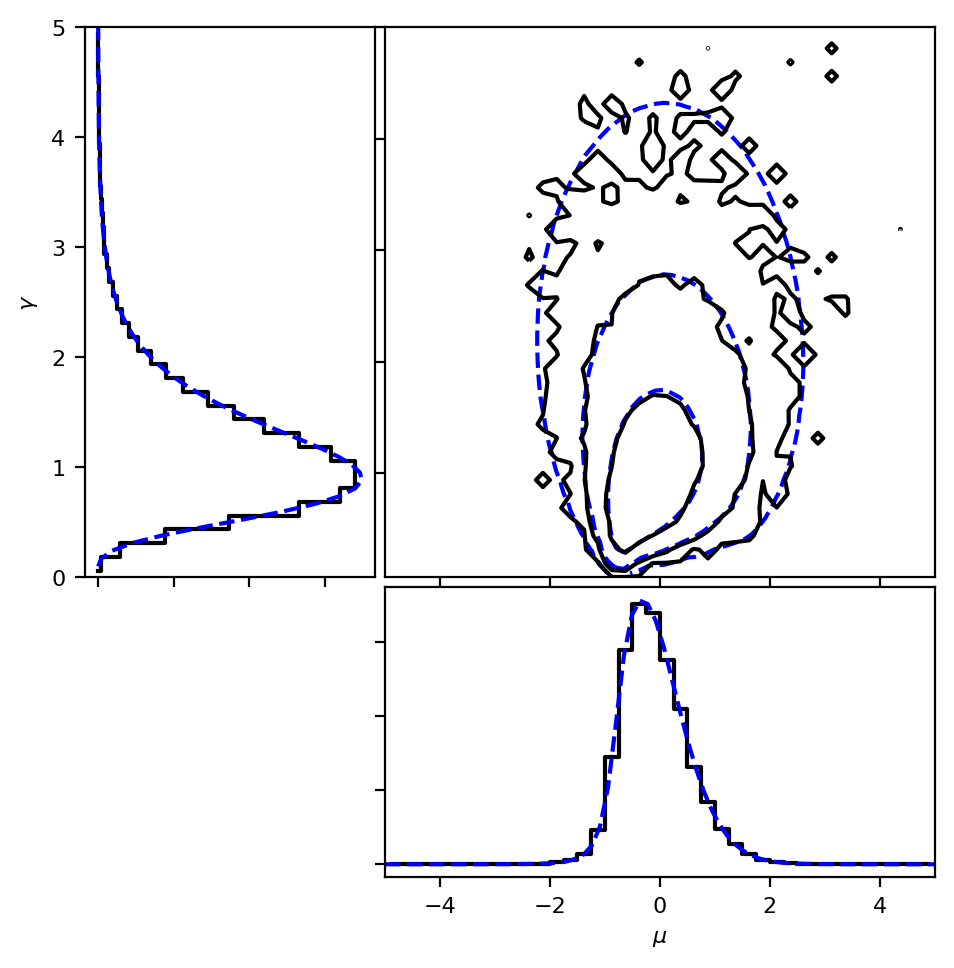

In [23]:
# ----------------------------------------------------------------------
# Plot all the results
fig = plt.figure(figsize=(5, 5))

# Bin centers (for contouring the MCMC 2D histogram)
mu_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])
gamma_centers = 0.5 * (gamma_bins[:-1] + gamma_bins[1:])

# ------------------------------------------------------------
# 1) Main panel: likelihood/posterior contours in (mu, gamma)
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

# Analytic contours (blue dashed)
ax1.contour(
    mu, gamma,
    convert_to_stdev(logL),
    levels=(0.683, 0.955, 0.997),
    colors="b",
    linestyles="dashed"
)

# MCMC contours from 2D histogram (black)
ax1.contour(
    mu_centers, gamma_centers,
    convert_to_stdev(np.log(L_MCMC.T)),
    levels=(0.683, 0.955, 0.997),
    colors="k"
)

# ------------------------------------------------------------
# 2) Left panel: marginalized over mu  → p(gamma)
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())

gamma_bin_centers = 0.5 * (bins_gamma[1:] + bins_gamma[:-1])

ax2.plot(hist_gamma, gamma_bin_centers, "-k", drawstyle="steps-mid")
ax2.plot(p_gamma, gamma, "--b")
ax2.set_ylabel(r"$\gamma$")
ax2.set_ylim(0, 5)

# ------------------------------------------------------------
# 3) Bottom panel: marginalized over gamma → p(mu)
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())

mu_bin_centers = 0.5 * (bins_mu[1:] + bins_mu[:-1])

ax3.plot(mu_bin_centers, hist_mu, "-k", drawstyle="steps-mid")
ax3.plot(mu, p_mu, "--b")
ax3.set_xlabel(r"$\mu$")
ax3.set_xlim(-5, 5)

plt.show()

The resulting $2$-D joint posterior pdf corner plot shows analytic results as blue dashed lines, and MCMC sampling results as black contours.

## Gibbs Sampling <a class="anchor" id="one"></a>

**Gibbs sampling** is an MCMC method that avoids acceptance–rejection steps altogether. Instead of proposing a full jump in parameter space, we **update one parameter at a time** by drawing directly from its *conditional posterior distribution*, while keeping all other parameters fixed at their current values.

After a sufficiently large number of such updates (called **Gibbs steps**), standard MCMC arguments guarantee that **the sequence of samples converges to the joint posterior distribution** of all model parameters.

A schematic of the Gibbs algorithm is shown below.

---
<p align="center">
  <img src="Gibbs.png" width="500">
</p>---

### The Gibbs algorithm in words

A single Gibbs step proceeds as follows:

- **Initialization:**  
  Start the sampler at some initial point in parameter space (this can be random).

- **Update the first parameter:**  
  Fix all parameters except the first one.  
  Draw a new value for this parameter from its conditional posterior distribution  
  $p(\theta_1 \mid \theta_2, \theta_3, \ldots, D)$.

- **Update the second parameter:**  
  Fix all parameters except the second one, using the updated value of the first parameter.  
  Draw a new value from  
  $p(\theta_2 \mid \theta_1, \theta_3, \ldots, D)$.

- **Continue sequentially:**  
  Repeat this procedure for all remaining parameters.

- **Iterate:**  
  One full sweep through all parameters constitutes **one Gibbs step**.  
  Repeat for many steps to build up a Markov chain.



## Benefits of Gibbs Sampling <a class="anchor" id="onea"></a>

- Because each update is drawn directly from the correct conditional posterior, every proposal is accepted.
- This often leads to **short auto-correlation lengths** and **very little burn-in**.
- When applicable, Gibbs sampling can be **computationally very efficient**.



## Drawbacks of Gibbs Sampling <a class="anchor" id="oneb"></a>

- Gibbs sampling requires knowing the analytic form of each conditional posterior distribution, and knowing how to sample from it.
- Deriving these conditionals can be mathematically involved, especially for realistic models.
- As a result, Gibbs sampling is typically practical only for models with special structure.



## Conjugate Priors (Again) <a class="anchor" id="onec"></a>

> *A conjugate prior is a prior distribution chosen such that the posterior distribution belongs to the same family as the prior.*

This concept is especially important for Gibbs sampling.

### Example: Gaussian likelihood

- Consider a Gaussian likelihood with mean $\mu$ and variance $\sigma^2$.
- If $\sigma^2$ is known, the conjugate prior for $\mu$ is a Gaussian distribution.  
  The conditional posterior for $\mu$ is therefore also Gaussian, since the product of two Gaussians is another Gaussian.
- If $\mu$ is known, the conjugate prior for $\sigma^2$ is an **inverse-gamma** distribution.  
  The conditional posterior for $\sigma^2$ is then also inverse-gamma.



Let's look at a speciifc example. We're going to analyze a homoescedastic Gaussian dataset. This is something we've done analytically in previous lectures but, crucially, this time search over the mean and standard deviation with MCMCs. I'll repeat a MH sampling first, and then we see how Gibbs sampling performs. 

In [25]:

# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time

In [26]:
np.random.seed(21)
Ndata = 200
mu = 1.0
sigma = 1.0
# Generate synthetic data
data = stats.norm(mu, sigma).rvs(Ndata)

#### Metropolis-Hastings Approach

Quick implementation with Metropolis-Hastings, using emcee here, which we can use for comparisson. 

In [27]:
def logLikelihood(x):
    # Gaussian likelihood 
    return np.sum(stats.norm(loc=x[0], scale=x[1]).logpdf(data))

def Prior(x):
    # create a uniform prior in mu and sigma
    prior_mu = stats.uniform.pdf(x[0], loc=0.5, scale=1.0)
    prior_sigma = stats.uniform.pdf(x[1], loc=0.5, scale=1.0)
    return  prior_mu * prior_sigma


def logPosterior(x):
    
    lp =  np.log(Prior(x))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return logLikelihood(x) + lp

###############


ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.array([1,1])+1e-3*np.random.randn(nwalkers, ndim)

In [28]:
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

elapsed=time.time()
sampler.run_mcmc(starting_guesses, nsteps)
print(time.time()-elapsed)

21.32147192955017


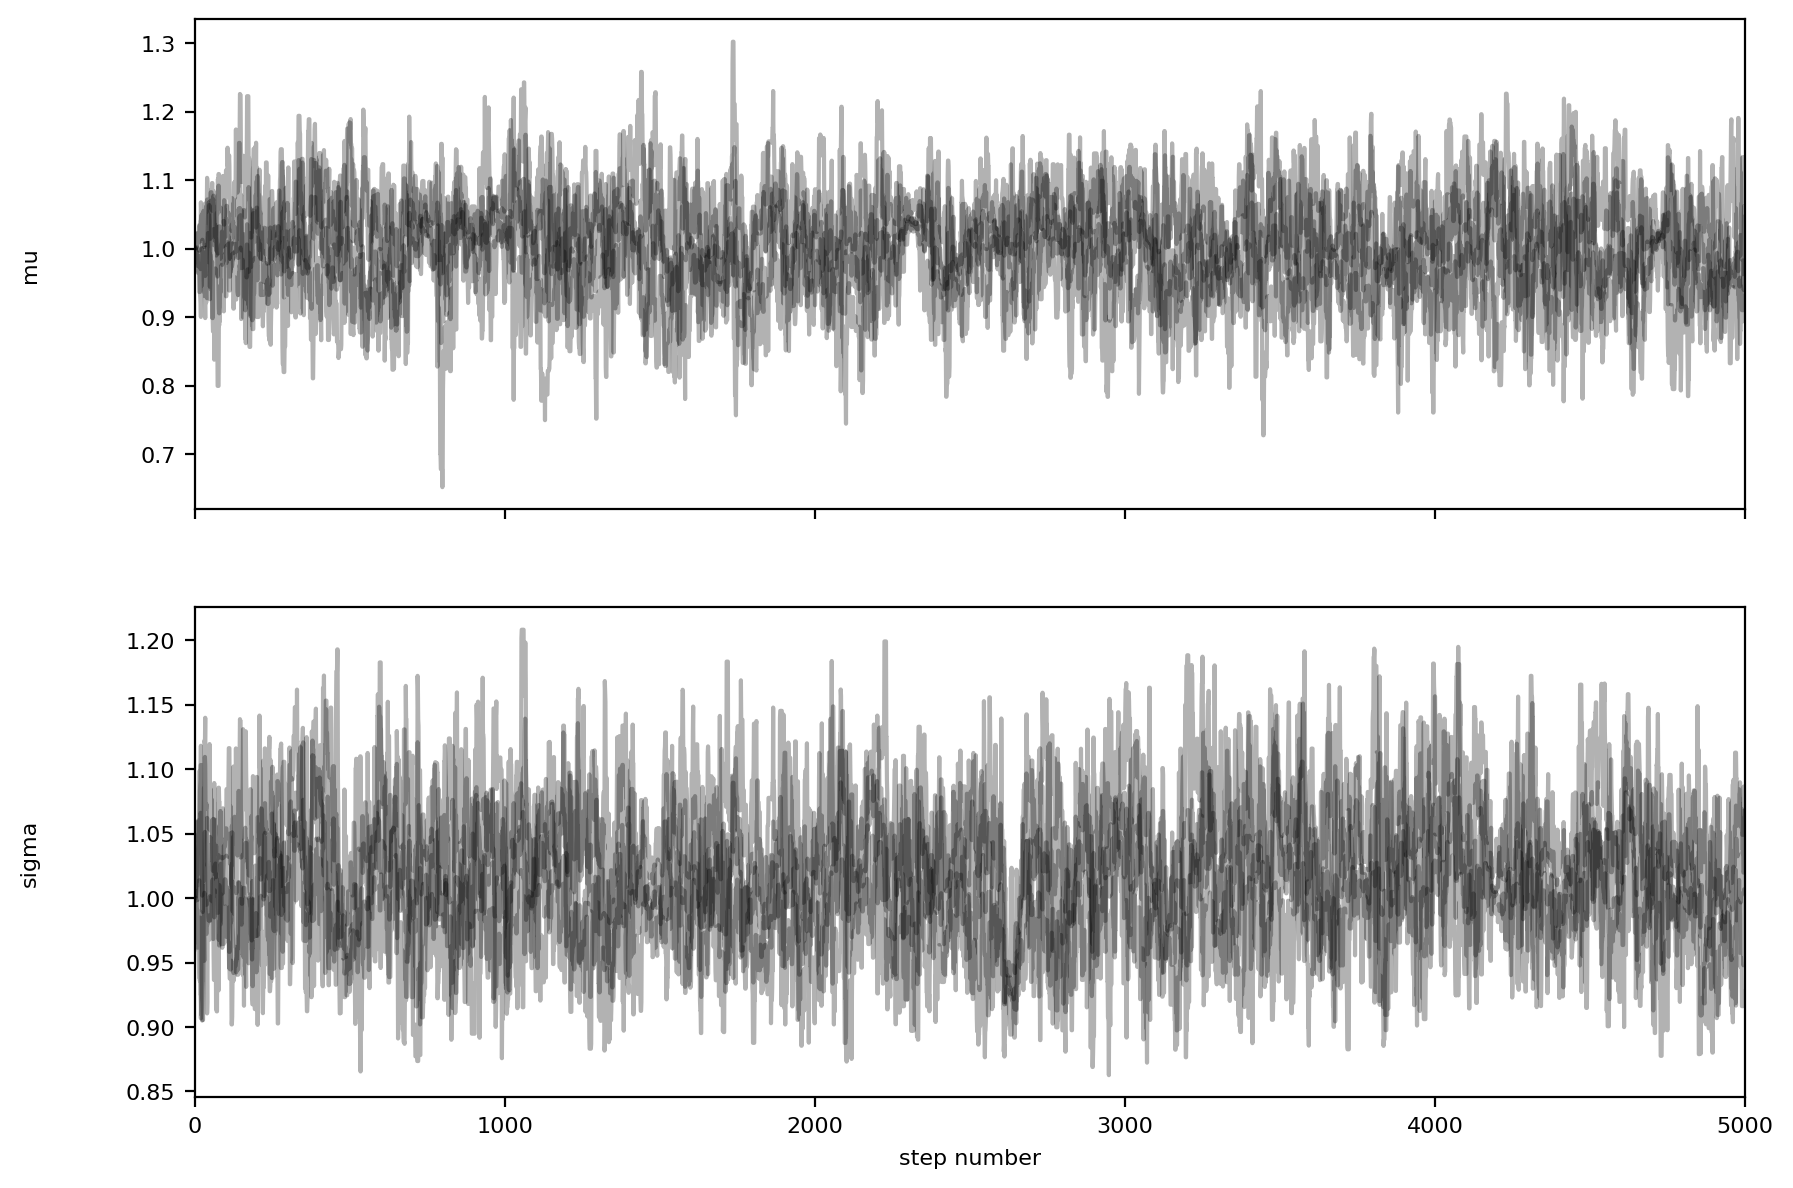

In [29]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mu","sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [30]:
tau = sampler.get_autocorr_time()
print(tau)

[36.47042084 30.59052577]


In [31]:
flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)
print(flat_samples.shape)

(815, 2)


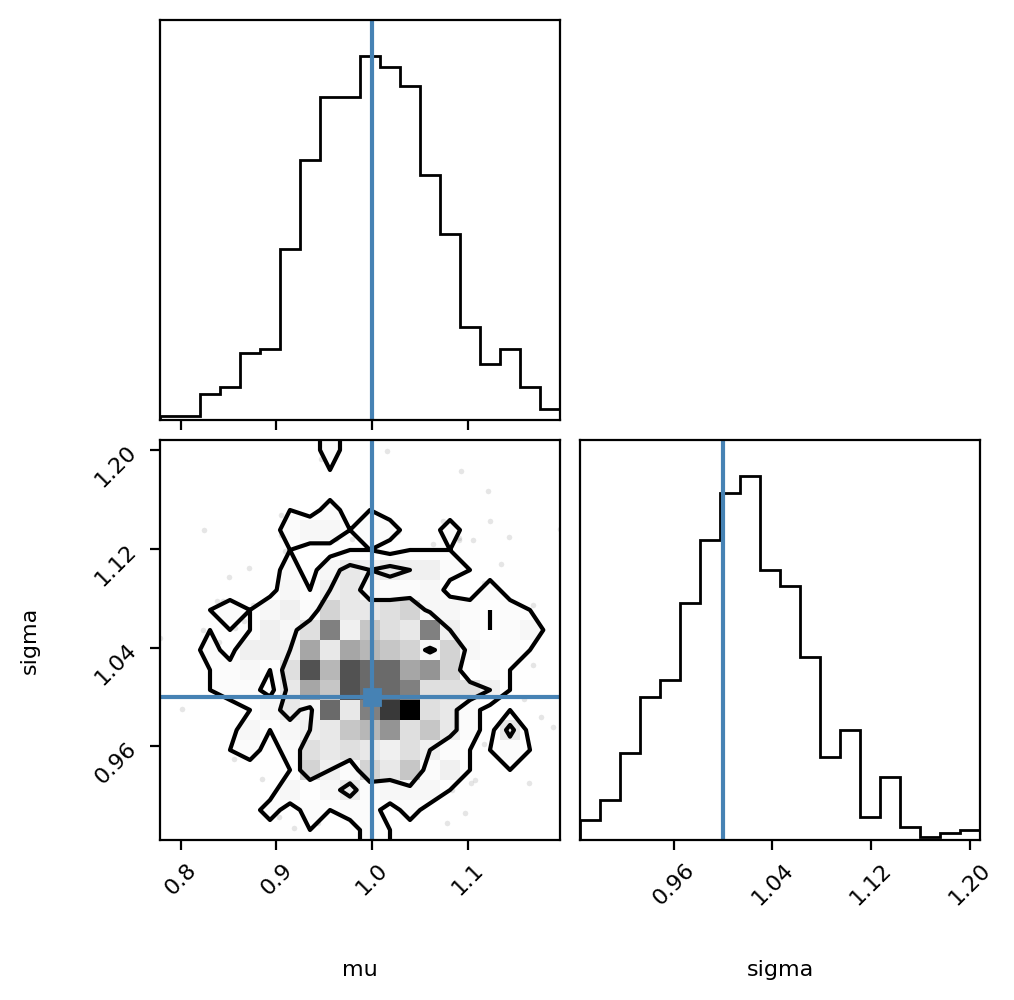

In [32]:
fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95],truths=[1,1]
);

**On the RUG HPC it took about 20 seconds. After burning and thinning, I got $815$ samples**

#### Gibbs Approach

We now move on to **Gibbs sampling** for this simple data set to see how it fairs against MH. 

The code for this example is adapted from:
- https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/
- https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html
- https://www.wikiwand.com/en/Conjugate_prior

---

### Model and priors

We assume the data $\{x_i\}_{i=1}^n$ are drawn from a Gaussian likelihood

$$
x_i \sim \mathcal{N}(\mu,\sigma^2),
$$

with both $\mu$ and $\sigma^2$ unknown.

To make Gibbs sampling possible, we choose **conjugate priors**, i.e. priors such that the conditional posteriors have the same functional form as the priors themselves.

- The conjugate prior for the mean $\mu$ (given $\sigma^2$) is a Gaussian:
  
$$
p(\mu) = \mathcal{N}(\mu_0,\sigma_0^2)
       = \frac{1}{\sqrt{2\pi\sigma_0^2}}
         \exp\!\left[-\frac{(\mu-\mu_0)^2}{2\sigma_0^2}\right].
$$

- The conjugate prior for the variance $\sigma^2$ (given $\mu$) is an **inverse-Gamma** distribution:

$$
p(\sigma^2) = \mathrm{IG}(\alpha,\beta)
= \frac{\beta^\alpha}{\Gamma(\alpha)}
  (\sigma^2)^{-(\alpha+1)}
  \exp\!\left(-\frac{\beta}{\sigma^2}\right).
$$

We choose these priors to be **broad**, so that the posterior inference is dominated by the data rather than prior assumptions.

---

### Conditional posterior distributions

By multiplying the likelihood with the appropriate prior, we can derive the **conditional posterior distributions** needed for Gibbs sampling.

1. **Conditional posterior for the mean $\mu$ (with $\sigma^2$ fixed):**

$$
p(\mu \mid \{x_i\}, \sigma^2)
= \mathcal{N}(\mu_\ast,\sigma_\ast^2),
$$

with

$$
\mu_\ast =
\left(\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1}
\left(\frac{\mu_0}{\sigma_0^2} + \frac{1}{\sigma^2}\sum_{i=1}^n x_i\right),
$$

$$
\sigma_\ast^2 =
\left(\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1}.
$$

2. **Conditional posterior for the variance $\sigma^2$ (with $\mu$ fixed):**

$$
p(\sigma^2 \mid \{x_i\}, \mu)
= \mathrm{IG}(\alpha_\ast,\beta_\ast),
$$

with

$$
\alpha_\ast = \alpha + \frac{n}{2},
$$

$$
\beta_\ast = \beta + \frac{1}{2}\sum_{i=1}^n (x_i - \mu)^2.
$$

These conditional distributions are standard probability distributions that we can sample from directly, making this model ideal for Gibbs sampling. You can check the lecture supplemental material for more information. 

In [33]:
# ------------------------------------------------------------
# Gibbs sampler for a Gaussian with unknown mean and variance
#
# Model:
#   x_i ~ Normal(mu, sigma^2)
#
# Priors (chosen conjugate so the conditional posteriors are standard):
#   mu      ~ Normal(mu0, sigma0^2)
#   sigma^2 ~ Inverse-Gamma(alpha, beta)
#
# ------------------------------------------------------------


def sample_mu_given_sigma2(sigma2, x, mu0, sigma0, rng=None):
    """
    Draw one sample from the conditional posterior p(mu | sigma^2, x).

    For known sigma^2, the posterior for mu is Gaussian:
      mu | sigma^2, x  ~ Normal(mu_star, sigma_star^2)

    where
      sigma_star^2 = 1 / ( 1/sigma0^2 + n/sigma^2 )
      mu_star      = sigma_star^2 * ( mu0/sigma0^2 + sum(x)/sigma^2 )
    """
    # Set up random number generator
    if rng is None:
        rng = np.random.default_rng()
    # Number of data points
    n = x.size

    # Posterior variance and mean (precision-weighted combination of prior + data)
    sigma_star2 = 1.0 / ((1.0 / sigma0**2) + (n / sigma2))
    mu_star = sigma_star2 * ((mu0 / sigma0**2) + (x.sum() / sigma2))

    return rng.normal(loc=mu_star, scale=np.sqrt(sigma_star2))


def sample_sigma2_given_mu(mu, x, alpha, beta, rng=None):
    """
    Draw one sample from the conditional posterior p(sigma^2 | mu, x).

    For known mu, the posterior for sigma^2 is inverse-gamma:
      sigma^2 | mu, x  ~ IG(alpha_star, beta_star)

    where
      alpha_star = alpha + n/2
      beta_star  = beta  + 0.5 * sum( (x - mu)^2 )
    """
    if rng is None:
        rng = np.random.default_rng()

    n = x.size
    alpha_star = alpha + 0.5 * n
    beta_star = beta + 0.5 * np.sum((x - mu) ** 2)

    # SciPy parameterization:
    #   stats.invgamma(a=shape, scale=scale)
    # corresponds to density proportional to (sigma^2)^(-a-1) * exp(-scale / sigma^2)
    return stats.invgamma.rvs(a=alpha_star, scale=beta_star, random_state=rng)


def gibbs_sampling(
    x,
    mu_initial,
    sigma2_initial,
    mu0,
    sigma0,
    alpha,
    beta,
    n_iter=2000,
    rng=None,
):
    """
    Run Gibbs sampling for (mu, sigma^2).

    Parameters
    ----------
    x : array-like
        Observed data values.
    mu_initial, sigma2_initial : float
        Starting values for the chain.
    mu0, sigma0 : float
        Hyperparameters of the Normal prior on mu: mu ~ Normal(mu0, sigma0^2).
    alpha, beta : float
        Hyperparameters of the inverse-gamma prior on sigma^2: sigma^2 ~ IG(alpha, beta).
    n_iter : int
        Total number of Gibbs iterations (including the initial state).
    rng : np.random.Generator, optional
        Random number generator for reproducibility.

    Returns
    -------
    samples : ndarray, shape (n_iter, 2)
        samples[t, 0] = mu at iteration t
        samples[t, 1] = sigma^2 at iteration t
    """
    if rng is None:
        rng = np.random.default_rng()

    x = np.asarray(x)

    samples = np.zeros((n_iter, 2), dtype=float)
    samples[0, 0] = mu_initial
    samples[0, 1] = sigma2_initial

    for t in range(1, n_iter):
        # 1) Update mu using the previous sigma^2
        mu_new = sample_mu_given_sigma2(
            sigma2=samples[t - 1, 1],
            x=x,
            mu0=mu0,
            sigma0=sigma0,
            rng=rng,
        )
        samples[t, 0] = mu_new

        # 2) Update sigma^2 using the newly updated mu
        sigma2_new = sample_sigma2_given_mu(
            mu=samples[t, 0],
            x=x,
            alpha=alpha,
            beta=beta,
            rng=rng,
        )
        samples[t, 1] = sigma2_new

    return samples

In [34]:
# starting point
mu_initial = 0.2
sigma2_initial = 0.6

# priors
mu0 = 1.0
sigma0 = 0.9
alpha = 1.0
beta = 1.0

## SAMPLE!
def run_gibbs():
    samples = gibbs_sampling(data, mu_initial, sigma2_initial, 
                             mu0, sigma0, alpha, beta)
    return samples

In [35]:
samples = run_gibbs()

Taking every n = 1 samples based on ac length.
Burning first n = 500 samples.


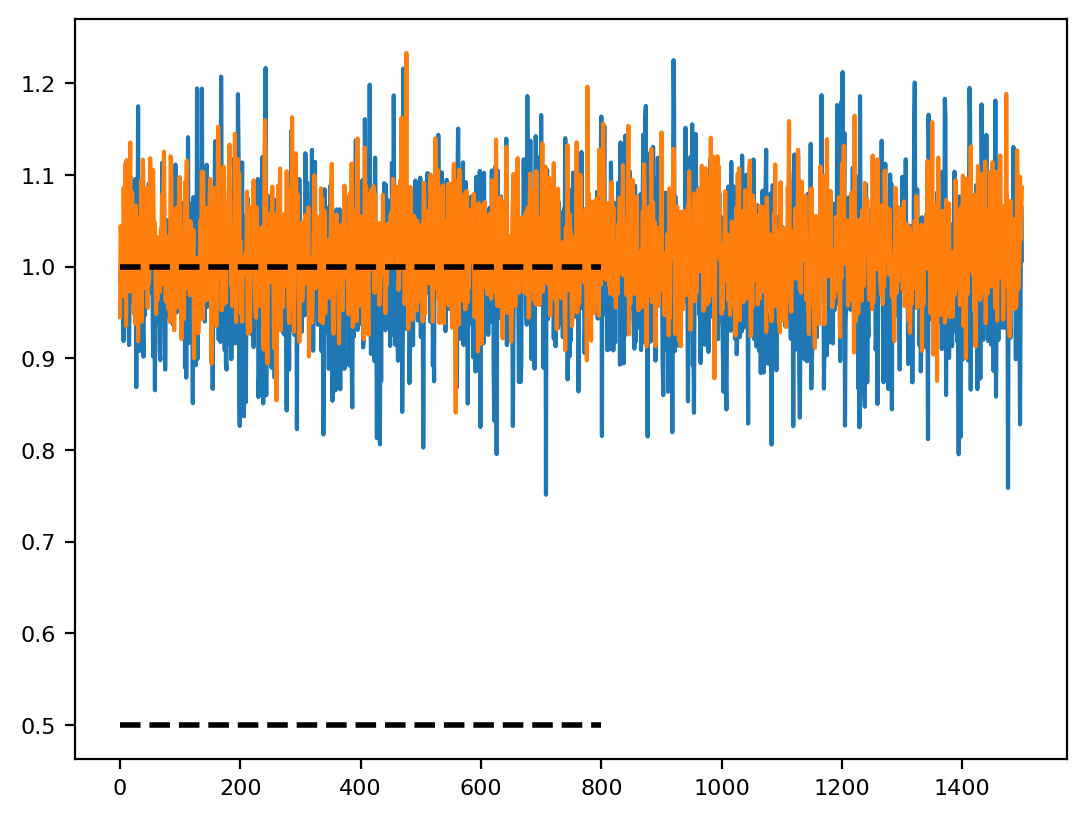

In [36]:
thin = int(emcee.autocorr.integrated_time(samples))+1
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(samples[500::thin,0]); # burned and thinned mean
plt.plot(samples[500::thin,1]**0.5); # burned and thinned sigma

# injected values
plt.hlines(1.0, 0.0, 800, color='k', lw=2, ls='dashed');
plt.hlines(0.5, 0.0, 800, color='k', lw=2, ls='dashed');

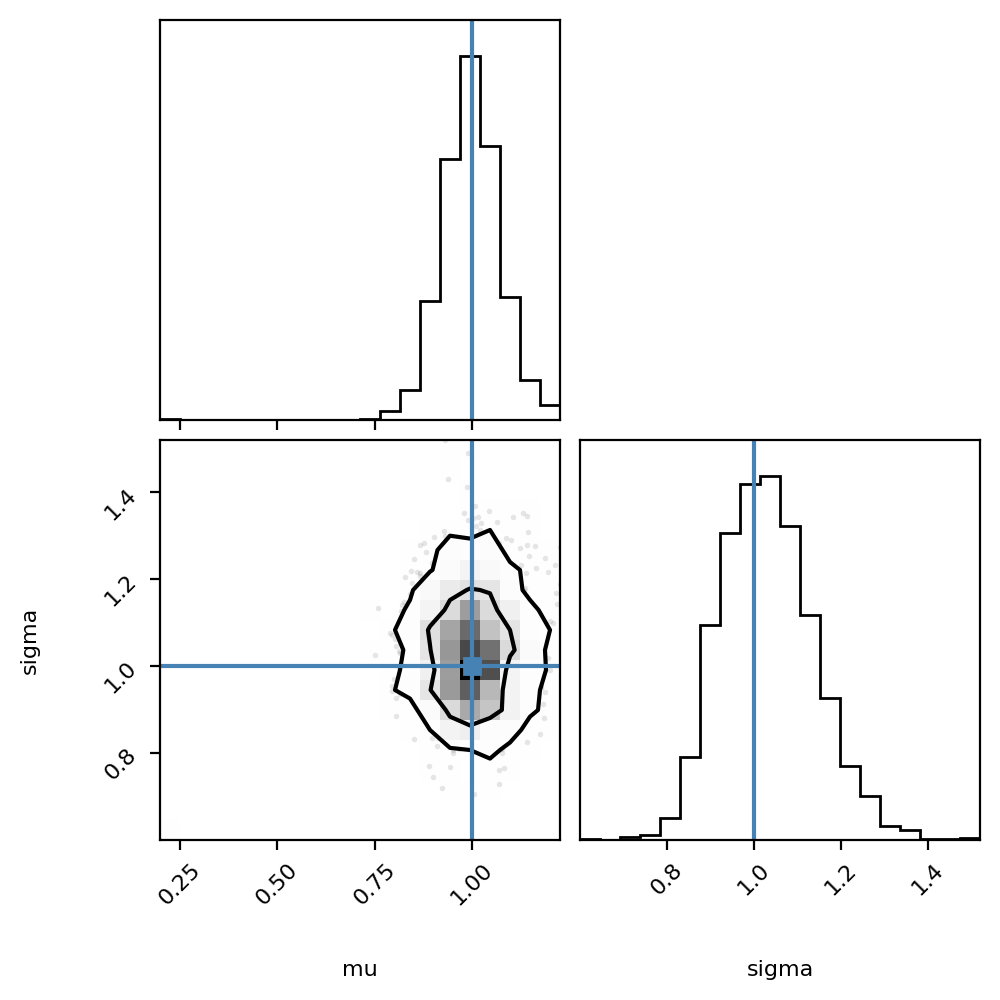

In [37]:
fig = corner.corner(
    samples, labels=labels, levels=[0.68,0.95],truths=[1,1]
);

Run the following code to time the Gibbs sampling of $2000$ posterior draws. No points are rejected. You'll see that this is about **two orders of magnitude faster than Metropolis-Hastings**, while also giving a greater number of sampled values.

In [38]:
%timeit -n1 run_gibbs()

126 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


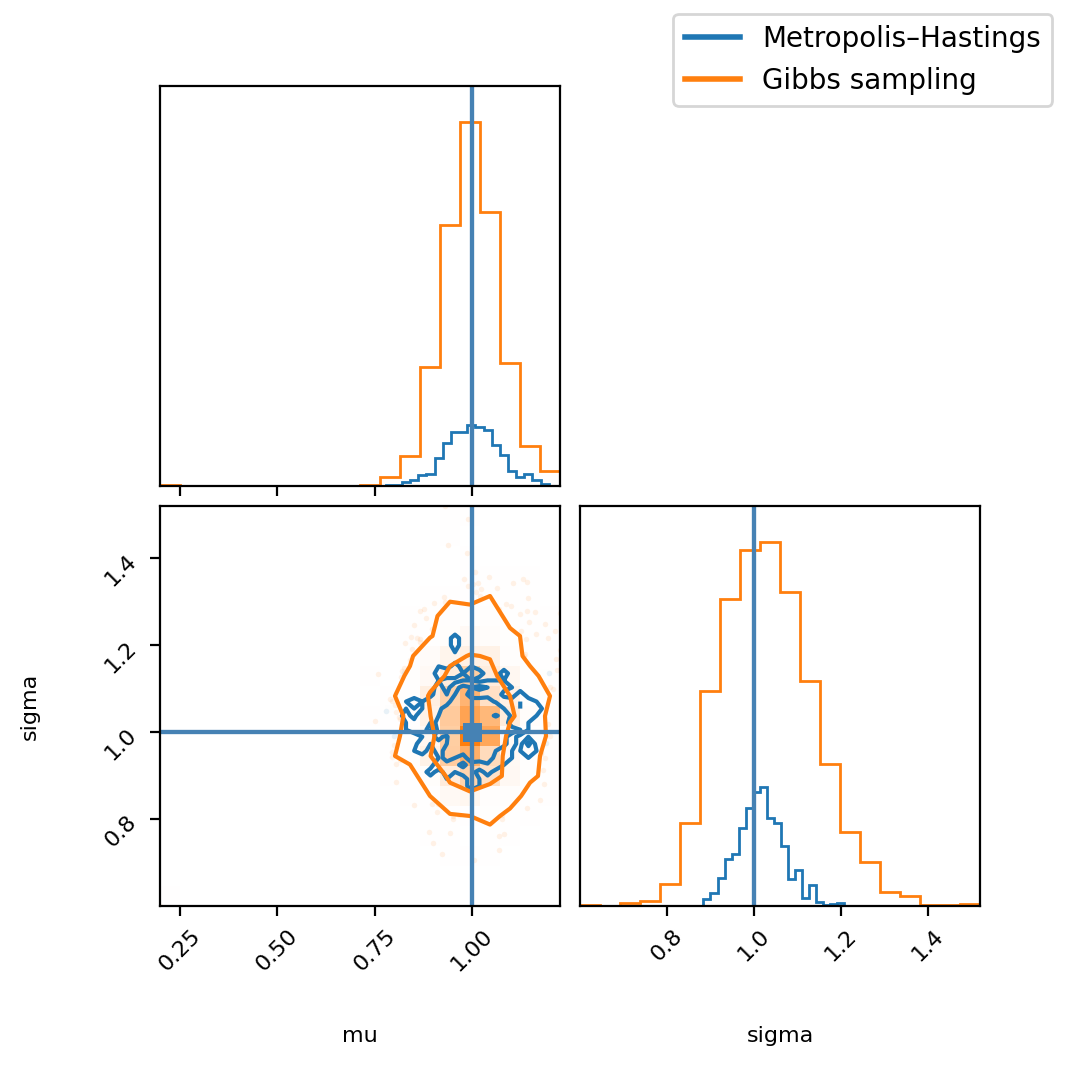

In [40]:
import corner
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

labels = ["mu", "sigma"]

fig = corner.corner(
    flat_samples,
    labels=labels,
    levels=[0.68, 0.95],
    truths=[1, 1],
    color="C0"
)

fig = corner.corner(
    samples,
    labels=labels,
    levels=[0.68, 0.95],
    truths=[1, 1],
    color="C1",
    fig=fig
)

# --- manual legend ---
legend_elements = [
    Line2D([0], [0], color="C0", lw=2, label="Metropolis–Hastings"),
    Line2D([0], [0], color="C1", lw=2, label="Gibbs sampling"),
]

fig.legend(
    handles=legend_elements,
    loc="upper right",
    fontsize=10
)

plt.show()

**Gibbs sampling is awesome...provided that you can work out the analytic conditional posteriors as standard distribution forms.** 

But even if you can't, all is not lost. You can get inventive by embedding a short Metropolis-Hastings block within the Gibbs algorithm. For example, if there are parameters for which you can not directly draw from the conditional, then your Gibbs step for that parameter could be a short Metropolis-Hastings MCMC run. 

The goal is to run this sufficiently long enough that you have drawn a single quasi-independent random sample from the parameter posterior conditional distribution, with all other parameters fixed. You can then proceed through the remainder of your Gibbs steps as normal. 

>## Assignment


One of the defining problems in **particle physics** is the search for new particles appearing as **resonances**: localized excesses (peaks) in an invariant-mass spectrum sitting on top of a smooth background.  

The Higgs boson discovery is the most famous example of this, but the *same statistical structure* appears throughout collider physics, astroparticle physics, and even cosmology.

In this assignment, you will analyze a **synthetic invariant-mass spectrum** inspired by Higgs-like searches and perform a **Bayesian parameter estimation** using MCMC techniques.

This is a *realistic research-style problem*, not an exam exercise. You are **encouraged** to consult documentation, tutorials, StackOverflow, and example code—this is exactly how real analyses are done.

---

### The data

You are provided with a NumPy file:  `data/higgs_binned.npy`.

This file contains a binned invariant-mass spectrum with shape `(N, 3)`:

- Column 1: invariant mass bin centers $m_i$ [GeV]  
- Column 2: observed number of events $n_i$ in each bin  
- Column 3: bin width $\Delta m$ [GeV]

The event counts in each bin follow **Poisson statistics**, as is standard for counting experiments in particle physics.

---

## Physical model

We model the data as a **signal + background** process:

- The **signal** is a narrow resonance, modeled as a Gaussian in invariant mass.
- The **background** is smooth and slowly varying, modeled as an exponential.

The expected number of events in bin $i$ is

$$
\lambda_i =
\Delta m \left[
A \exp\!\left( -\frac{(m_i - \mu)^2}{2\sigma^2} \right)
+ B \exp(-\alpha m_i)
\right],
$$

where:
- $\mu$: resonance mass [GeV]  
- $\sigma$: resonance width [GeV]  
- $A$: signal normalization  
- $B$: background normalization  
- $\alpha$: background slope  

You may fix $\sigma$ if you wish to reduce the dimensionality of the problem, or keep it as a free parameter.

---

## Likelihood

Because the data consist of **event counts**, the appropriate likelihood is **Poisson**, not Gaussian:

$$
\ln \mathcal{L} =
\sum_i \left[
n_i \ln \lambda_i - \lambda_i - \ln(n_i!)
\right].
$$

This choice is essential for correctly modeling counting experiments.

---

## Tasks

### 1️⃣ Data exploration
- Load `higgs_binned.npy`.
- Plot the invariant-mass spectrum.
- Include appropriate error bars (use $\sqrt{n_i}$ for Poisson uncertainties).
- Clearly label axes and units.

---

### 2️⃣ Model and likelihood
- Implement the signal + background model described above.
- Write a function that computes the **log-likelihood** for the data given model parameters.

---

### 3️⃣ Bayesian inference with MCMC
Using **either** `emcee` **or** `PyMC`:

- Define priors for the model parameters. Reasonable choices are, for example:
  - $\mu \in \mathrm{Uniform}[110, 140]$ GeV  
  - $\sigma \in \mathrm{Uniform}[0.5, 5]$ GeV (if not fixed)  
  - $A \in \mathrm{Uniform}[0, 10^4]$  
  - $B \in \mathrm{Uniform}[0, 5\times 10^4]$  
  - $\ln \alpha \in \mathrm{Uniform}[-5, 1]$

- Run an MCMC sampler to obtain posterior samples of the parameters.
- Justify your choice of number of walkers, chains, and total samples.

---

### 4️⃣ Convergence and burn-in
- Inspect trace plots for all parameters.
- Decide on a suitable burn-in period and discard it.
- Estimate the autocorrelation length and thin the chain accordingly.
- Explain how you verified that the chain is sampling a stationary distribution.

---

### 5️⃣ Posterior visualization
- Make a **corner plot** of the posterior distribution:
  - Include parameter labels and units.
  - Show 68% and 95% credible contours.
  - Mark median values and credible intervals.

---

### 6️⃣ Posterior predictive check
- Randomly select 100 samples from the burned and thinned chain.
- For each sample, compute the predicted invariant-mass spectrum.
- Plot these 100 spectra on top of the data using transparency.

This visualizes the **posterior uncertainty in the signal and background model**.

---

### 7️⃣ Parameter estimates
For each parameter:
- Quote the **median** value.
- Quote the **90% credible interval**, for example
$$
\mu = 125.3^{+1.8}_{-1.5}\,\mathrm{GeV}.
$$

Briefly interpret the physical meaning of your results.

---

## Optional extensions (not required)

- Compare a **background-only model** to the signal + background model using Bayesian evidence.
- Investigate how sensitive your results are to the choice of priors.
- Replace the exponential background with a polynomial and discuss the impact.

---

### Final note

This assignment mirrors the structure of real analyses performed at the LHC and in astroparticle physics. There is no single “correct” implementation—what matters is **clear reasoning, correct statistical treatment, and transparent presentation of results**.
